In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [4]:
def lorentzian(x,c,gam,a,y0):
    return y0 + (2*a/np.pi)*gam/(4*(x-c)**2 + gam**2)

def ext_BW(freq, ydata, plot=False):
    
    ymin = np.min(ydata)
    ymax = np.max(ydata)

     #initial guess
    left_index = np.where(ydata > 0.5*(ymax+ymin)) [0][0]    #FWHM
    right_index = np.where(ydata > 0.5*(ymax+ymin))[0][-1]   #FWHM
    BW_g = freq[right_index] - freq[left_index]
    wc_g = freq[np.argmax(ydata)]
    a_g = 0.5*np.pi*(ymax-ymin)*BW_g
    y0_g = ymin


    res, cov = curve_fit(lorentzian,freq,ydata,[wc_g, BW_g, a_g, y0_g])

    
    f0, bw = res[0], res[1]
    f0_err, bw_err = np.sqrt(cov[0,0]), np.sqrt(cov[1,1])

    a, y0 = res[2], res[3]
    a_err, y0_err = np.sqrt(cov[2,2]), np.sqrt(cov[3,3])

    H = 2*a/(np.pi*bw)
    H_err = H*(a_err/a + bw_err/bw) 
    y_xc = H + y0
    y_xc_err = H_err + y0_err
    
    r = (y0 - y_xc)/(y0 + y_xc)
    r_err = r*(y0_err + y_xc_err)*(1/(-y0 + y_xc) + 1/(-y0 - y_xc))

    kint = bw/(1+r)
    kext = bw*r/(1+r)

    kint_err = kint*(bw_err/bw + r_err/(r+1))
    kext_err = bw_err + kint_err
    
    Qint = f0/kint
    Qext = f0/kext
    
    Qint_err = Qint*(f0_err/f0 + kint_err/kint)
    Qext_err = Qext*(f0_err/f0 + kext_err/kext)

    
        
    f0 = np.round(f0*1e-9,10)
    f0_err = np.round(f0_err*1e-9,10)
    bw = np.round(bw*1e-9,10)
    bw_err = np.round(bw_err*1e-9,10)
    kint = np.round(kint*1e-9,10)
    kext = np.round(kext*1e-9,10)
    kint_err = np.round(kint_err*1e-9,10)
    kext_err = np.round(kext_err*1e-9,10)
    
    if plot:
        plt.plot(freq*1e-9, ydata, label = "Data")
        plt.plot(freq*1e-9, lorentzian(freq, res[0], res[1], res[2], res[3]), c = 'r',label = "Fit")
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Measured ReS11")
        plt.grid()
        plt.legend()
        plt.show()
        print("Cavity Frequency = {0} GHz; Total Bandwidth = {1} MHz".format(f0, 1e3*bw))
        print("Internal Bandwidth = {0} MHz; External Bandwidth = {1} MHz".format(1e3*kint,1e3*kext))
        
    out1 = [(f0, f0_err), (1e3*kint, 1e3*kint_err), (1e3*kext, 1e3*kext_err)]
    out2 = [(Qint, Qint_err), (Qext,Qext_err)]
    
    return out1, out2 ,res, np.sqrt(np.diag(cov))


In [ ]:
data = np.transpose(np.loadtxt('CavityResponse_forAakif.txt', dtype= str))
freq= [float(freq) for freq in data[0]]
ydata= [float(ydat) for ydat in data[1]]

freq = np.array(freq)
ydata = np.array(ydata)



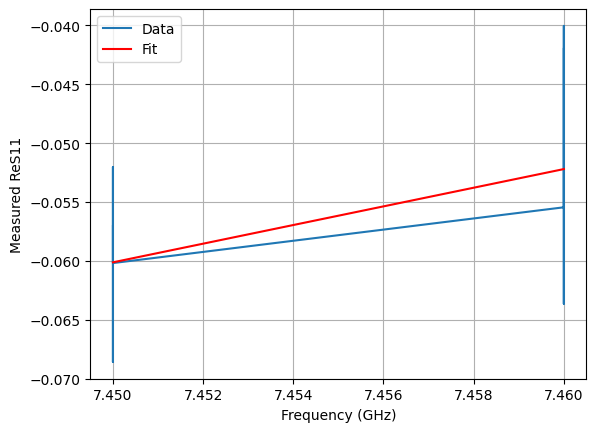

Cavity Frequency = 7.4594911777 GHz; Total Bandwidth = 12.824640599999999 MHz
Internal Bandwidth = 11.6537863 MHz; External Bandwidth = 1.1708543 MHz


In [10]:
meas_vals, q_vals, fit_param, fit_error = ext_BW(freq, ydata, plot=True)

In [11]:
#fit_param
fit_error

array([2.34710733e+20, 1.90763909e+20, 1.70713506e+18, 1.13509550e+11])

In [12]:
pmin, pmax = -100, 10
del_p = 10
p_vals = np.arange(pmin,pmax + del_p -1, del_p)

kint_list, kext_list = [], []
Qint_list, Qext_list = [], []
fit_param_list =[]
Q_with_pow_list=[]

for p in p_vals:
    
    filepath = f'F:\Expt Data\\2023-03-20 Ta_res02_L2, FLX_2Q_dev02 and its brother\\2023-03-28 after 2nd cycle Ta_res Py\data_{p}.0_dBm.txt'
    print(filepath)
   
    data= np.transpose(np.loadtxt(filepath))
    freq=data[0]
    ydata=data[1]

    meas_vals, q_vals, fit_param, fit_error = ext_BW(freq, ydata, plot=True)
    
    fit_param_list.append([p, fit_param[0],fit_error[0], fit_param[1],fit_error[1],fit_param[2],fit_error[2],fit_param[3],fit_error[3]])
    Q_with_pow_list.append([p, meas_vals[0][0],q_vals[0][0], q_vals[0][1],q_vals[1][0], q_vals[1][1]])
    
    kint_list.append(meas_vals[1])
    kext_list.append(meas_vals[2])
    
    Qint_list.append(q_vals[0])
    Qext_list.append(q_vals[1])
np.savetxt("F:\\Expt Data\\2023-03-20 Ta_res02_L2, FLX_2Q_dev02 and its brother\\2023-03-28 after 2nd cycle Ta_res Py\\Lorentian_fit_params_with_power.txt", fit_param_list, header="Power Freq Freq_err BW BW_err A A_err y0 y0_err")
np.savetxt("F:\\Expt Data\\2023-03-20 Ta_res02_L2, FLX_2Q_dev02 and its brother\\2023-03-28 after 2nd cycle Ta_res Py\\Q_with_power.txt", Q_with_pow_list, header="Power Freq Qint Qint_err Qext Qext_err")

F:\Expt Data\2023-03-20 Ta_res02_L2, FLX_2Q_dev02 and its brother\2023-03-28 after 2nd cycle Ta_res Py\data_-100.0_dBm.txt


FileNotFoundError: F:\Expt Data\2023-03-20 Ta_res02_L2, FLX_2Q_dev02 and its brother\2023-03-28 after 2nd cycle Ta_res Py\data_-100.0_dBm.txt not found.

In [ ]:
fit_param_list

[['Power', 'Freq', 'Qint', 'Qint_err', 'Qext', 'Qext_err'],
 array([-9.00000000e+01,  4.94161484e+00,  1.93950618e+05,  1.15521169e+05,
         3.93675034e+04,  7.27618877e+03]),
 array([-8.00000000e+01,  4.94161781e+00,  2.10597505e+05,  4.43217689e+04,
         3.62819134e+04,  1.99797638e+03]),
 array([-7.00000000e+01,  4.94161843e+00,  1.74434147e+05,  1.02029380e+04,
         3.58356627e+04,  6.55885220e+02]),
 array([-6.00000000e+01,  4.94161840e+00,  1.85844646e+05,  8.20077439e+03,
         3.60755128e+04,  4.70269929e+02]),
 array([-5.00000000e+01,  4.94161848e+00,  2.22653323e+05,  3.78539048e+03,
         3.60084588e+04,  1.50155922e+02]),
 array([-4.00000000e+01,  4.94161844e+00,  2.79219537e+05,  3.06761329e+03,
         3.59773681e+04,  7.69667142e+01]),
 array([-3.00000000e+01,  4.94161858e+00,  3.77882796e+05,  6.55250005e+03,
         3.59518654e+04,  8.92944579e+01]),
 array([-2.00000000e+01,  4.94161815e+00,  4.94655272e+05,  8.28693148e+03,
         3.59814160e+04,

[]

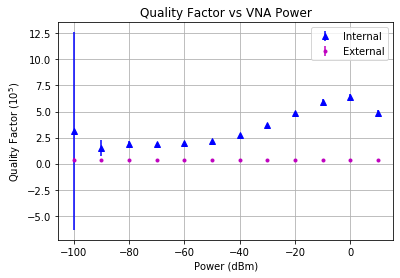

In [ ]:
Qint_vals = np.array([Qint[0] for Qint in Qint_list])
Qint_err_vals = np.array([Qint[1] for Qint in Qint_list])
Qext_vals = np.array([Qext[0] for Qext in Qext_list])
Qext_err_vals = np.array([Qext[1] for Qext in Qext_list])

plt.errorbar(p_vals, 1e-5*Qint_vals, fmt="b^", label = "Internal", yerr=1e-5*Qint_err_vals, linestyle = None)
plt.errorbar(p_vals, 1e-5*Qext_vals, fmt="m.", label = "External", yerr=1e-5*Qext_err_vals, linestyle = None)
plt.xlabel("Power (dBm)")
plt.ylabel("Quality Factor ($10^5$)")
plt.title("Quality Factor vs VNA Power")
plt.grid()
plt.legend()
plt.plot()


[]

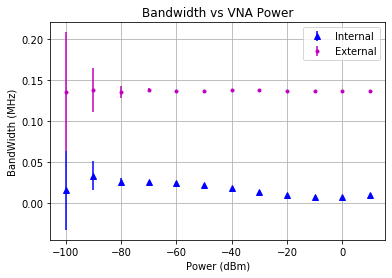

In [ ]:
kint_vals = np.array([kint[0] for kint in kint_list])
kint_err_vals = np.array([kint[1] for kint in kint_list])
kext_vals = np.array([kext[0] for kext in kext_list])
kext_err_vals = np.array([kext[1] for kext in kext_list])

plt.errorbar(p_vals, kint_vals, fmt="b^", label = "Internal", yerr=kint_err_vals, linestyle = None)
plt.errorbar(p_vals, kext_vals, fmt="m.", label = "External", yerr=kext_err_vals, linestyle = None)
plt.xlabel("Power (dBm)")
plt.ylabel("BandWidth (MHz)")
plt.title("Bandwidth vs VNA Power")
plt.grid()
plt.legend()
plt.plot()

In [ ]:
np.where(np.array([0,1,2,3,4,5,6])>2.5)[0]

array([3, 4, 5, 6], dtype=int64)

In [ ]:
a=[[1,2,3],[4,5,6],[7,8,9]]

In [ ]:
np.diag(a)

array([1, 5, 9])